# Space Charge on the GPU

PyHEADTAIL offers space charge models which are accelerated on graphics processing units (GPUs).

Space charge refers to the impact of the beam's self-fields on itself. In PyHEADTAIL, we model space charge by lumped kicks, which are applied after each tracking segment. The kicks correspond to the integrated space charge effect over the tracked segment's length.

In the present notebook we demonstrate the transverse defocussing effect of space charge and the corresponding tune spread for a Gaussian distribution.

In the first part of the notebook we use a fixed non-selfconsistent Gaussian field map: the actually tracked beam then moves like test particles through the correspondingly generated fields. In the second part we solve for the fields generated by the particle distribution, once for a Gaussian and once for an root-mean-square equivalent Kapchinskij-Vladimirskij distribution. 

For a more in-depth discussion of the two methods, you may refer to http://frs.web.cern.ch/frs/Source/space_charge/Meetings/meeting98_17.08.2017/oeftiger_sc_modelling.pdf .

Note that this tutorial requires a GPU with the NVIDIA `CUDA` suite and the python package `PyCUDA` installed (at least for the fields solving section).

All additional packages can be installed from https://github.com/PyCOMPLETE/ .

-- 2018, Adrian Oeftiger

# Preparations

In [1]:
from __future__ import division, print_function

import numpy as np
np.random.seed(42)

from scipy.constants import c, epsilon_0, e, m_p

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import h5py

In [2]:
from pycuda.autoinit import context
from pycuda import gpuarray as gp

In [3]:
import sys, os, shutil
sys.path.append('/home/oeftiger/PyHEADTAIL/')
sys.path.append('/home/oeftiger/tunespreadtool/tunespreadtool')
sys.path.append('/home/oeftiger/tune_diagram/')

In [4]:
from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.spacecharge.spacecharge import TransverseGaussianSpaceCharge
from PyHEADTAIL.spacecharge.pypic_factory import create_mesh, create_3dmesh_from_beam
from PyHEADTAIL.spacecharge.pypic_spacecharge import SpaceChargePIC
from PyHEADTAIL.monitors.monitors import ParticleMonitor

from PyHEADTAIL.general.printers import SilentPrinter
from PyHEADTAIL.general.contextmanager import CPU, GPU

PyHEADTAIL v1.12.4.3


PyKLU not found


In [5]:
contextmanager = CPU

In [6]:
from PyCERNmachines.CERNmachines import SPS

In [7]:
from PySussix import Sussix
import tunespread
import libtunespread
from tune_diagram import ResonanceLines

In [8]:
n_macroparticles = int(1e4)
n_slices_sc = 32

intensity = 1.3e11
epsn_x = epsn_y = 2e-6 # in [m.rad]
sigma_z = 0.23 # in [m]

In [9]:
def make_machine(n_segments=200):
    return SPS(n_segments=n_segments,
               machine_configuration='Q20-injection',
               optics='smooth',
               printer=SilentPrinter(),
               Q_x=20.26,
               Q_y=20.31,
              )

def make_beam(machine=make_machine(), n_macroparticles=n_macroparticles):
    return machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles, intensity, epsn_x, epsn_y, sigma_z)

In [10]:
m = make_machine()
beam = make_beam(m)

sig_x = beam.sigma_x()
sig_y = beam.sigma_y()

slicing_interval = m.longitudinal_map.get_bucket(beam).interval

slicer_sc = UniformBinSlicer(n_slices_sc, z_cuts=slicing_interval)

*** PyHEADTAIL WARNING! RFBucketMatcher: failed to converge with Brent method, continuing with Newton-Raphson method.


RMS equivalent KV tune shift due to space charge:

In [11]:
lmbda = intensity * e / (np.sqrt(2*np.pi) * sigma_z)
Ksc = e / (beam.gamma**3 * m_p * (beam.beta * c)**2) * lmbda / (2*np.pi*epsilon_0)
R = m.circumference / (2*np.pi)

def dQ_inc(thissize, theothersize, thistune, Ksc=Ksc):
    'incoherent KV tune shift'
    return Ksc * R**2 / (4 * thistune * thissize * (thissize+theothersize))

print ('dQ_x = {0:.3f} and dQ_y = {1:.3f}'.format(
    dQ_inc(beam.sigma_x(), beam.sigma_y(), m.Q_x), 
    dQ_inc(beam.sigma_y(), beam.sigma_x(), m.Q_y)))

dQ_x = 0.062 and dQ_y = 0.062


In [12]:
assert (m.optics == 'smooth')
sc_integration_length = m.circumference / len(m.transverse_map)

sc_node = TransverseGaussianSpaceCharge(slicer=slicer_sc, length=sc_integration_length)

m.install_after_each_transverse_segment(sc_node)

# Tracking

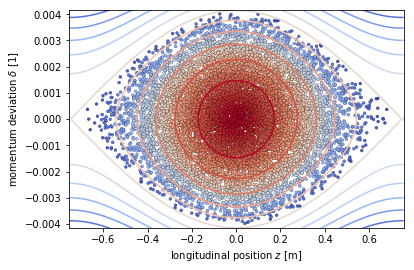

In [13]:
rfsystems = m.longitudinal_map
rfbucket = rfsystems.get_bucket(beam)

zz = np.linspace(*rfbucket.interval, num=1000)
dp_max = rfbucket.separatrix(0)
dpp = np.linspace(-dp_max*1.1, dp_max*1.1, num=100)
ZZ, DPP = np.meshgrid(zz, dpp)
HH = rfbucket.hamiltonian(ZZ, DPP)

plt.scatter(beam.z, beam.dp, marker='.', c=rfbucket.hamiltonian(beam.z, beam.dp), 
            cmap=plt.get_cmap('coolwarm'), edgecolor='black', linewidths=0.2)
plt.contour(ZZ, DPP, HH, 15, cmap=plt.get_cmap('coolwarm'))
plt.xlim(rfbucket.interval)
plt.ylim(-dp_max, dp_max)
plt.xlabel('longitudinal position $z$ [m]')
plt.ylabel('momentum deviation $\delta$ [1]');

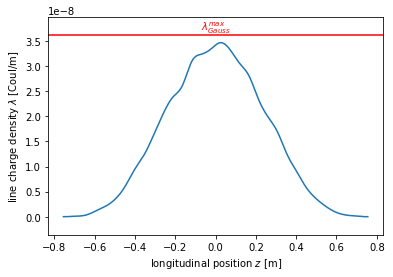

In [14]:
plt.plot(zz,beam.get_slices(slicer_sc).lambda_z(zz, smoothen=True))
plt.axhline(lmbda, color='red')
plt.text(0, lmbda, r"$\lambda^{max}_{Gauss}$", 
         verticalalignment='bottom', 
         horizontalalignment='center', color='red')
plt.ylim(-0.1*lmbda, 1.1*lmbda)
plt.xlabel('longitudinal position $z$ [m]')
plt.ylabel('line charge density $\lambda$ [Coul/m]');

In [15]:
transv_one_turn_map = [el for el in m.one_turn_map if el is not m.longitudinal_map]

In [16]:
n_turns = 128

In [17]:
pmonitor = ParticleMonitor(filename='./pmon_sc', stride=beam.macroparticlenumber // 1000)

Attention, the tracking takes a while:

In [18]:
with contextmanager(beam):
    for _ in range(n_turns):
        for el in transv_one_turn_map:
            el.track(beam)
        pmonitor.dump(beam)

# Incoherent tune analysis

Also the reading of the particle tracking data into memory takes a while:

In [19]:
with h5py.File("pmon_sc.h5part") as pmon:
    ids = np.array(pmon['Step#0']['id'])
    n_sussix_turns = len(pmon.keys())
    id_i = np.array([pmon['Step#{turn}'.format(turn=turn)]['id']
                     for turn in range(n_sussix_turns)]).T
    x_i = np.array([pmon['Step#{turn}'.format(turn=turn)]['x']
                    for turn in range(n_sussix_turns)]).T
    xp_i = np.array([pmon['Step#{turn}'.format(turn=turn)]['xp']
                     for turn in range(n_sussix_turns)]).T
    y_i = np.array([pmon['Step#{turn}'.format(turn=turn)]['y']
                    for turn in range(n_sussix_turns)]).T
    yp_i = np.array([pmon['Step#{turn}'.format(turn=turn)]['yp']
                     for turn in range(n_sussix_turns)]).T

# if AssertionError: particles among selected ones [:n_particles] got lost!
assert np.all(np.std(id_i, axis=1) == 0)

In [20]:
Qx = m.Q_x
Qy = m.Q_y

In [21]:
randomdir = ''.join('%02x' % ord(x) for x in os.urandom(16))
while os.path.exists(randomdir):
    randomdir = ''.join('%02x' % ord(x) for x in os.urandom(16))
cwd = os.getcwd()
os.makedirs(randomdir)
os.chdir(randomdir)

qx_i = np.empty(len(ids))
qy_i = np.empty(len(ids))

for p_idx in range(len(qx_i)):
    SX = Sussix()
    SX.sussix_inp(nt1=1, nt2=n_sussix_turns, idam=2, ir=0, 
                  tunex=Qx % 1, tuney=Qy % 1, istun=[1, 0.25, 0.25, 0.25])
    SX.sussix(x_i[p_idx,:],
              xp_i[p_idx,:],
              y_i[p_idx,:],
              yp_i[p_idx,:],
              x_i[p_idx,:],
              xp_i[p_idx,:])
    qx_i[p_idx] = SX.ox[0]
    qy_i[p_idx] = SX.oy[0]

    sys.stdout.write('\rparticle {p_idx} out of {n_particles}'.format(
        p_idx=p_idx + 1, n_particles=len(qx_i)))
    sys.stdout.flush()

os.chdir(cwd)
shutil.rmtree(randomdir)

print('\nDone!')

particle 1000 out of 1000
Done!


## tunespreadtool to compare the smooth approximation lattice with the real TWISS lattice (dispersion $D_x=0$ removed)

In [22]:
tst_inputs = dict(
    mass=beam.mass * c**2/beam.charge * 1e-9,
    beta=beam.beta,
    gamma=beam.gamma,
    sig_z=beam.sigma_z(),
    n_part=beam.intensity,
    deltap=beam.sigma_dp(),
    emit_geom_x=beam.epsn_x() / beam.betagamma,
    emit_geom_y=beam.epsn_y() / beam.betagamma,
    lshape=1,#1.6/1.73,#lshape, # <<< !!!
    n_charges_per_part=1
)

twiss_filename = "./sps_optics_selected1200.dat"

# SELECTED LATTICE Laslett tune spread analysis
with open(twiss_filename, 'r') as f:
    lbls = f.readline().split()[1:]
    data = np.genfromtxt(f, unpack=True)

tst_data = {var.lower(): array for var, array in zip(lbls, data)}
# tst_dQ_x, tst_dQ_y = tunespread.calc_tune_spread(tst_data, tst_inputs, True)
tst_data_Dx0 = tst_data.copy()
tst_data_Dx0["d_x"].fill(0)
tst_Dx0_dQ_x, tst_Dx0_dQ_y = tunespread.calc_tune_spread(tst_data_Dx0, tst_inputs, True)

integrated 100.00% (item 1199 out of 1199)



In [23]:
print ("TWISS lattice Gaussian space charge tune spread: dQx = {:.3f}, dQy = {:.3f}".format(
    tst_Dx0_dQ_x, tst_Dx0_dQ_y
))

TWISS lattice Gaussian space charge tune spread: dQx = 0.124, dQy = 0.125


In [24]:
# smooth approximation
print ("theoretical Gaussian space charge tune spread: dQx = {:.3f}, dQy = {:.3f}".format(
    dQ_inc(beam.sigma_x(), beam.sigma_y(), m.Q_x) * 2,  
    dQ_inc(beam.sigma_y(), beam.sigma_x(), m.Q_y) * 2
))

theoretical Gaussian space charge tune spread: dQx = 0.122, dQy = 0.123


All data points selected for plot: False


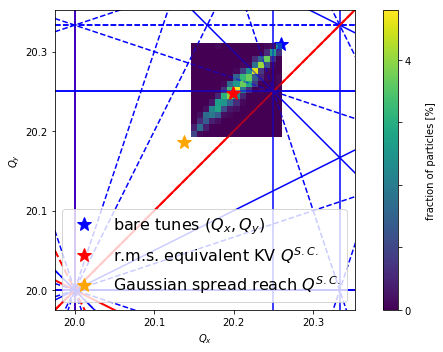

In [25]:
fig = plt.figure(figsize=(8,5)) 
# resonances = ResonanceLines((np.floor(Qx)-0.008, np.floor(Qx)+0.16), 
#                             (np.floor(Qy)-0.01, np.floor(Qy)+0.3), 
#                             range(1, 4+1), 6)
resonances = ResonanceLines((19.975, 20.525), (19.975, 20.525),
                            range(1, 4+1), 6)
resonances.plot_resonance(fig)
np.atleast_1d(fig.get_axes())[-1].set_aspect('equal')

inc_tunes_x = np.floor(Qx) + np.abs(qx_i)
inc_tunes_y = np.floor(Qy) + np.abs(qy_i)
selected = np.logical_and(np.logical_and(np.floor(Qx) + 0.002 < inc_tunes_x, inc_tunes_x < Qx - 0.002),
                          np.logical_and(np.floor(Qy) + 0.005 < inc_tunes_y, inc_tunes_y < Qy - 0.005))
print ("All data points selected for plot: " + str(np.all(selected)))
plot_x = inc_tunes_x#[selected]
plot_y = inc_tunes_y#[selected]

# plt.plot(Qx, Qy, 'b*', ms=15, label=r"bare tune $Q$")
# plt.plot(Qx - tst_dQ_x, Qy - tst_dQ_y, 'b*', ms=15, label=r"$Q^{S.C.}$ for $D_x\neq\,0$")
# plt.plot(Qx - tst_Dx0_dQ_x, Qy - tst_Dx0_dQ_y, 'g*', ms=15, label=r"$Q^{S.C.}$ for $D_x=\,0$")

# plt.legend(loc=2, numpoints=1, fontsize=16, labelspacing=0.1).get_frame().set_facecolor("white")

# plt.scatter(plot_x, plot_y, 
#             marker='o', lw=0.1, alpha=1,#0.3, 
#             vmin=np.min(z_i), vmax=np.max(z_i), s=35, 
#             c=z_i[:,-1],#[selected], 
#             cmap=cmap, norm=norm, 
#             zorder=10)

# plt.hist2d(plot_x, plot_y, bins=20, cmap=my_l_r, zorder=2, alpha=0.5)
# plt.hist2d(plot_x, plot_y, bins=20, cmap=my_l_r)

# cbar = plt.colorbar()#spacing='proportional', cmap=cmap, norm=norm, 
                    #ticks=bounds, boundaries=bounds)
# cbar.set_label("$z$ [m]")



plt.hist2d(plot_x, plot_y, bins=15,
           zorder=2, alpha=0.5, weights=np.ones_like(plot_x)/len(plot_x)*100)
plt.hist2d(plot_x, plot_y, bins=15, 
           weights=np.ones_like(plot_x)/len(plot_x)*100)
cbar = plt.colorbar()

plt.plot(Qx, Qy, 'b*', ms=15, label=r"bare tunes $(Q_x,Q_y)$")
# plt.plot(Qx - tst_dQ_x, Qy - tst_dQ_y, 'b*', ms=15, label=r"$Q^{S.C.}$ for $D_x\neq\,0$")

plt.plot(Qx - dQ_inc(beam.sigma_x(), beam.sigma_y(), m.Q_x), 
         Qy - dQ_inc(beam.sigma_y(), beam.sigma_x(), m.Q_y), 
         marker='*', ls='none', color='red', ms=15, label=r"r.m.s. equivalent KV $Q^{S.C.}$", zorder=10)
plt.plot(Qx - 2 * dQ_inc(beam.sigma_x(), beam.sigma_y(), m.Q_x), 
         Qy - 2 * dQ_inc(beam.sigma_y(), beam.sigma_x(), m.Q_y), 
         marker='*', ls='none', color='orange', ms=15, label=r"Gaussian spread reach $Q^{S.C.}$", zorder=10)


plt.setp(cbar.ax.get_yticklabels()[::], visible=False)
plt.setp(cbar.ax.get_yticklabels()[::4], visible=True)
cbar.set_label('fraction of particles [%]', labelpad=15)

myLocator = mpl.ticker.MultipleLocator(0.1)
plt.gca().xaxis.set_major_locator(myLocator)
plt.gca().yaxis.set_major_locator(myLocator)

# plt.grid()

# plt.xlim(20.2, 20.34)
# plt.ylim(20.24, 20.38)

plt.xlim((19.975, 20.3525))
plt.ylim((19.975, 20.3525))

# plt.xlim((20.15, 20.35))
# plt.ylim((20.2, 20.4))

plt.legend(loc=4, numpoints=1, fontsize=16)

plt.tight_layout()
# plt.savefig('tune diagram.pdf', bbox_inches='tight')


# plt.xlim((20.22, 20.25))
# plt.ylim((20.22, 20.25))

# plt.tight_layout()
# plt.savefig(directory + 'tune diagram zoom.pdf', bbox_inches='tight')

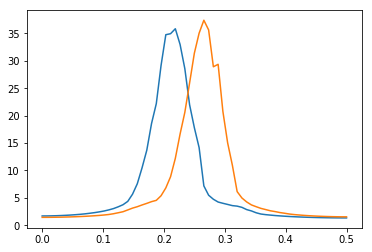

In [26]:
ffts_x = map(np.abs, map(np.fft.rfft, x_i))
ffts_y = map(np.abs, map(np.fft.rfft, y_i))

plt.plot(np.fft.rfftfreq(n_turns), np.sum(ffts_x, axis=0))
plt.plot(np.fft.rfftfreq(n_turns), np.sum(ffts_y, axis=0))

# field solving with self-consistent particle-in-cell algorithms

In [27]:
from PyHEADTAIL.particles.generators import kv4D, transverse_linear_matcher

In [28]:
from PyPIC.GPU.poisson_solver.FFT_solver import GPUFFTPoissonSolver_2_5D
from PyPIC.GPU.pypic import PyPIC_GPU

# not necessary but nice: memory pool sharing between PyHEADTAIL and PyPIC
try:
    from PyHEADTAIL.gpu.gpu_utils import memory_pool
except:
    memory_pool = None

In [29]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.constants import epsilon_0

In [30]:
# self-consistent PIC solving for space charge
n_mesh_nodes_pic = 128
n_mesh_sigma_pic = 5

In [31]:
mesh_3d = create_3dmesh_from_beam(beam, [n_mesh_nodes_pic]*2, [n_mesh_sigma_pic]*2, 
                                  slices=beam.get_slices(slicer_sc))

In [32]:
poissonsolver = GPUFFTPoissonSolver_2_5D(mesh_3d, context=context, save_memory=False)
pypic_algorithm = PyPIC_GPU(mesh_3d, poissonsolver, context=context, 
                            memory_pool=memory_pool)
pic_sc_node = SpaceChargePIC(sc_integration_length, pypic_algorithm)

In [33]:
contextmanager = GPU

In [34]:
class State(object):
    pass
pypic_state = State()

## Gaussian distribution

In [35]:
beam = make_beam(m, n_macroparticles=n_macroparticles*100)

*** PyHEADTAIL WARNING! RFBucketMatcher: failed to converge with Brent method, continuing with Newton-Raphson method.


In [36]:
with contextmanager(beam):
    pic_sc_node.track(beam, pypic_state)

In [37]:
Ex = pypic_state.mesh_e_fields[0].get()
Ex_bunchcenter = Ex[slicer_sc.n_slices // 2, :, :]

In [38]:
def plot3d(x, y, efield, angles=(30, 30)):
    XX = x*1e3 # in [mm]
    YY = y*1e3 # in [mm]
    ey = efield * 1e-3 # in [kV/m]
    
    prev_rcParams = mpl.rcParams.copy()
    mpl.rcParams.update( {
            'xtick.major.pad': 4,
            'ytick.major.pad': 4,
    } )

    locator = mpl.ticker.MultipleLocator(base=3)
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(*angles)
    s = ax.plot_surface(XX, YY, ey, rstride=5, cstride=5, alpha=0.7,
                        cmap=plt.get_cmap('coolwarm'), linewidth=0.1, edgecolors='grey', zorder=2)
    # s = ax.plot_trisurf(XX, YY, ey, alpha=0.5, 
    #                     cmap=cm.coolwarm, linewidth=0.1)
    ax.set_xlim3d(ax.get_xlim3d()*1.1)
    ax.set_ylim3d(ax.get_ylim3d()*1.1)
    ax.set_zlim3d(ax.get_zlim3d()*1.1)
    ax.contourf(XX, YY, ey, zdir='z', offset=ax.get_zlim()[0], cmap=plt.get_cmap('coolwarm'), alpha=0.5, zorder=1)
    ax.contourf(XX, YY, ey, 10, zdir='y', offset=ax.get_ylim()[0], cmap=plt.get_cmap('coolwarm'), alpha=0.5, zorder=1)
    ax.contourf(XX, YY, -ey, zdir='x', offset=ax.get_xlim()[0], cmap=plt.get_cmap('coolwarm'), alpha=0.5, zorder=1)
    
    ax.set_xlabel('$x$ [mm]', fontsize=18, labelpad=15)
    ax.set_ylabel('$y$ [mm]', fontsize=18, labelpad=15)
    zlab = ax.set_zlabel('$E_x$ [kV/m]', fontsize=18, labelpad=15)

    # ax.xaxis.set_major_locator(locator)
    # ax.yaxis.set_major_locator(locator)
    # plt.colorbar(s)
    plt.tight_layout()

    # plt.savefig('ey.png', bbox_inches='tight')

    mpl.rcParams = prev_rcParams
    return ax

XX, YY = np.meshgrid(np.arange(mesh_3d.x0, mesh_3d.x0 + mesh_3d.dx*mesh_3d.nx, mesh_3d.dx), 
                     np.arange(mesh_3d.y0, mesh_3d.y0 + mesh_3d.dy*mesh_3d.ny, mesh_3d.dy))

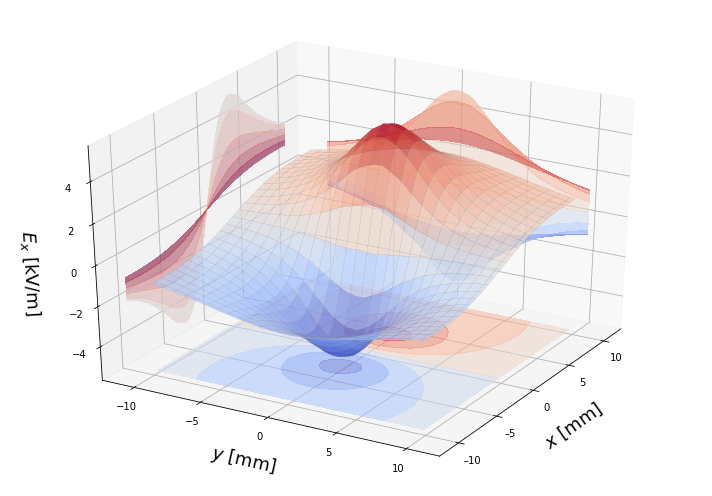

In [39]:
ax = plot3d(XX, YY, -Ex_bunchcenter)
ax.xaxis.set_ticklabels(reversed([u"–10",u"–5","0", "5", "10"]));

# extent = plt.gca().get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
# extent.x1 -= 0.5
# extent.y1 -= 0.2
# plt.savefig('/home/oeftiger/SPS_Ey.pdf', bbox_inches=extent) #'tight')

## RMS equivalent KV beam:

In [40]:
beam = make_beam(m, n_macroparticles=n_macroparticles * 100)

*** PyHEADTAIL WARNING! RFBucketMatcher: failed to converge with Brent method, continuing with Newton-Raphson method.


In [41]:
r_x = 2 * np.sqrt(epsn_x / beam.betagamma)
r_y = 2 * np.sqrt(epsn_y / beam.betagamma)
r_xp = 2 * np.sqrt(epsn_x / beam.betagamma)
r_yp = 2 * np.sqrt(epsn_y / beam.betagamma)

beam.x, beam.xp, beam.y, beam.yp = kv4D(
    r_x, r_xp, r_y, r_yp)(beam.macroparticlenumber)

matchor_x = transverse_linear_matcher(
    alpha=m.alpha_x[0], beta=m.beta_x[0],
    dispersion=m.D_x[0]
)
matchor_y = transverse_linear_matcher(
    alpha=m.alpha_y[0], beta=m.beta_y[0],
    dispersion=m.D_y[0]
)

matchor_x(beam, ['x', 'xp'])
matchor_y(beam, ['y', 'yp'])

In [42]:
with contextmanager(beam):
    pic_sc_node.track(beam, pypic_state)

In [43]:
Ex = pypic_state.mesh_e_fields[0].get()
Ex_bunchcenter = Ex[slicer_sc.n_slices // 2, :, :]

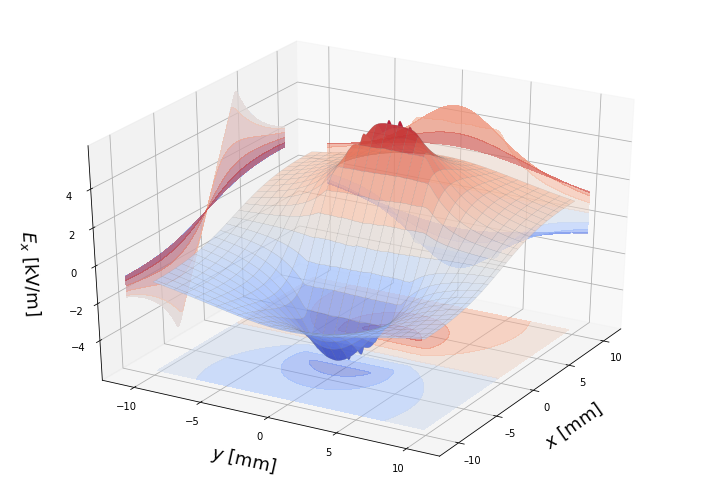

In [44]:
ax = plot3d(XX, YY, -Ex_bunchcenter)
ax.xaxis.set_ticklabels(reversed([u"–10",u"–5","0", "5", "10"]));

# extent = plt.gca().get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
# extent.x1 -= 0.5
# extent.y1 -= 0.2
# plt.savefig('/home/oeftiger/SPS_Ey.pdf', bbox_inches=extent) #'tight')

In [45]:
print ('Gaussian RMS size: {:.3f}mm\nvs.   KV RMS size: {:.3f}mm'.format(
    sig_x * 1e3, beam.sigma_x() * 1e3
))

Gaussian RMS size: 1.993mm
vs.   KV RMS size: 1.986mm


$~\longrightarrow~$ Gaussian electric field inclination in the bunch centre is double the one of the KV beam (cf. projection)

$~\Longrightarrow~$ Gaussian maximum tune shift must be twice the value of the KV tune shift